In [253]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency, pearsonr, spearmanr

# Font settings
mpl.rcParams['font.family'] = 'NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False  # Prevent minus sign issues


orgDf = pd.read_csv('../../datasets/credit_card_fraud_dataset.csv')
orgDf.head()

,TransactionID,TransactionDate,Amount,MerchantID,TransactionType,Location,IsFraud
0,1,2024-04-03 14:15:35.462794,4189.27,688,refund,San Antonio,0
1,2,2024-03-19 13:20:35.462824,2659.71,109,refund,Dallas,0
2,3,2024-01-08 10:08:35.462834,784.00,394,purchase,New York,0
3,4,2024-04-13 23:50:35.462850,3514.40,944,purchase,Philadelphia,0
4,5,2024-07-12 18:51:35.462858,369.07,475,purchase,Phoenix,0


제안 2: 이상 거래 탐지
- 문제 정의:
    +  거래 데이터(Amount, TransactionType, Location, IsFraud)를 바탕으로 이상 거래를 탐지하고, 거래 사기 가능성을 예측합니다.
- 목표:
    + 거래 금액의 분포 및 이상치 탐색
    + 거래 유형별 사기 발생률 비교
    + 사기 거래가 자주 발생하는 지역 및 시간대 식별
-   배경:
    + 이상 거래를 조기에 탐지함으로써 사기 방지 시스템을 강화하고, 금융 손실을 줄일 수 있습니다.

In [254]:
orgDf.info(), orgDf.index, orgDf.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   TransactionID    100000 non-null  int64  
 1   TransactionDate  100000 non-null  object 
 2   Amount           100000 non-null  float64
 3   MerchantID       100000 non-null  int64  
 4   TransactionType  100000 non-null  object 
 5   Location         100000 non-null  object 
 6   IsFraud          100000 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 5.3+ MB


(None,
 RangeIndex(start=0, stop=100000, step=1),
        TransactionID         Amount     MerchantID        IsFraud
 count  100000.000000  100000.000000  100000.000000  100000.000000
 mean    50000.500000    2497.092666     501.676070       0.010000
 std     28867.657797    1442.415999     288.715868       0.099499
 min         1.000000       1.050000       1.000000       0.000000
 25%     25000.750000    1247.955000     252.000000       0.000000
 50%     50000.500000    2496.500000     503.000000       0.000000
 75%     75000.250000    3743.592500     753.000000       0.000000
 max    100000.000000    4999.770000    1000.000000       1.000000)

In [255]:
orgDf['Amount'].describe()

count    100000.000000
mean       2497.092666
std        1442.415999
min           1.050000
25%        1247.955000
50%        2496.500000
75%        3743.592500
max        4999.770000
Name: Amount, dtype: float64

In [256]:
len(orgDf['MerchantID'].value_counts()), orgDf['MerchantID'].value_counts()

(1000,
 MerchantID
 461    149
 188    134
 192    129
 517    128
 820    126
       ... 
 119     75
 936     74
 968     73
 635     71
 512     69
 Name: count, Length: 1000, dtype: int64)

In [257]:
orgDf['IsFraud'].value_counts()

IsFraud
0    99000
1     1000
Name: count, dtype: int64

In [258]:
orgDf['Location'].value_counts() 

Location
Chicago         10193
San Diego       10111
Dallas          10076
San Antonio     10062
New York         9993
Houston          9991
Phoenix          9960
Los Angeles      9936
Philadelphia     9873
San Jose         9805
Name: count, dtype: int64

In [259]:
fraud = orgDf[orgDf['IsFraud'] == 1]


In [260]:
fraud['Location'].value_counts()

Location
New York        116
San Diego       115
Houston         105
Phoenix          99
Dallas           99
San Antonio      99
Chicago          95
Los Angeles      95
Philadelphia     90
San Jose         87
Name: count, dtype: int64

In [261]:
rateOfPurchase = (orgDf['Location'].value_counts()) / 100000
rateOfPurchase

Location
Chicago         0.10193
San Diego       0.10111
Dallas          0.10076
San Antonio     0.10062
New York        0.09993
Houston         0.09991
Phoenix         0.09960
Los Angeles     0.09936
Philadelphia    0.09873
San Jose        0.09805
Name: count, dtype: float64

In [262]:
rateOfFraudByLoc = (fraud['Location'].value_counts()) / 1000
rateOfFraudByLoc

Location
New York        0.116
San Diego       0.115
Houston         0.105
Phoenix         0.099
Dallas          0.099
San Antonio     0.099
Chicago         0.095
Los Angeles     0.095
Philadelphia    0.090
San Jose        0.087
Name: count, dtype: float64

In [263]:
orgDf['TransactionDate'].info, orgDf['TransactionDate'].describe(), orgDf['TransactionDate'].value_counts(), orgDf['TransactionDate'].index

(<bound method Series.info of 0        2024-04-03 14:15:35.462794
 1        2024-03-19 13:20:35.462824
 2        2024-01-08 10:08:35.462834
 3        2024-04-13 23:50:35.462850
 4        2024-07-12 18:51:35.462858
                     ...            
 99995    2024-06-07 00:57:36.027591
 99996    2023-10-22 23:12:36.027594
 99997    2024-05-31 19:27:36.027597
 99998    2024-10-18 09:43:36.027601
 99999    2024-03-05 19:41:36.027606
 Name: TransactionDate, Length: 100000, dtype: object>,
 count                         100000
 unique                        100000
 top       2023-10-30 06:53:36.027441
 freq                               1
 Name: TransactionDate, dtype: object,
 TransactionDate
 2023-10-30 06:53:36.027441    1
 2024-07-11 10:55:36.027444    1
 2023-11-23 08:37:36.027449    1
 2024-09-07 05:03:36.027453    1
 2024-03-29 11:33:36.027457    1
                              ..
 2024-04-13 23:50:35.462850    1
 2024-07-12 18:51:35.462858    1
 2024-08-30 01:52:35.462867    1
 20

### 거래 금액의 분포 및 이상치 탐색

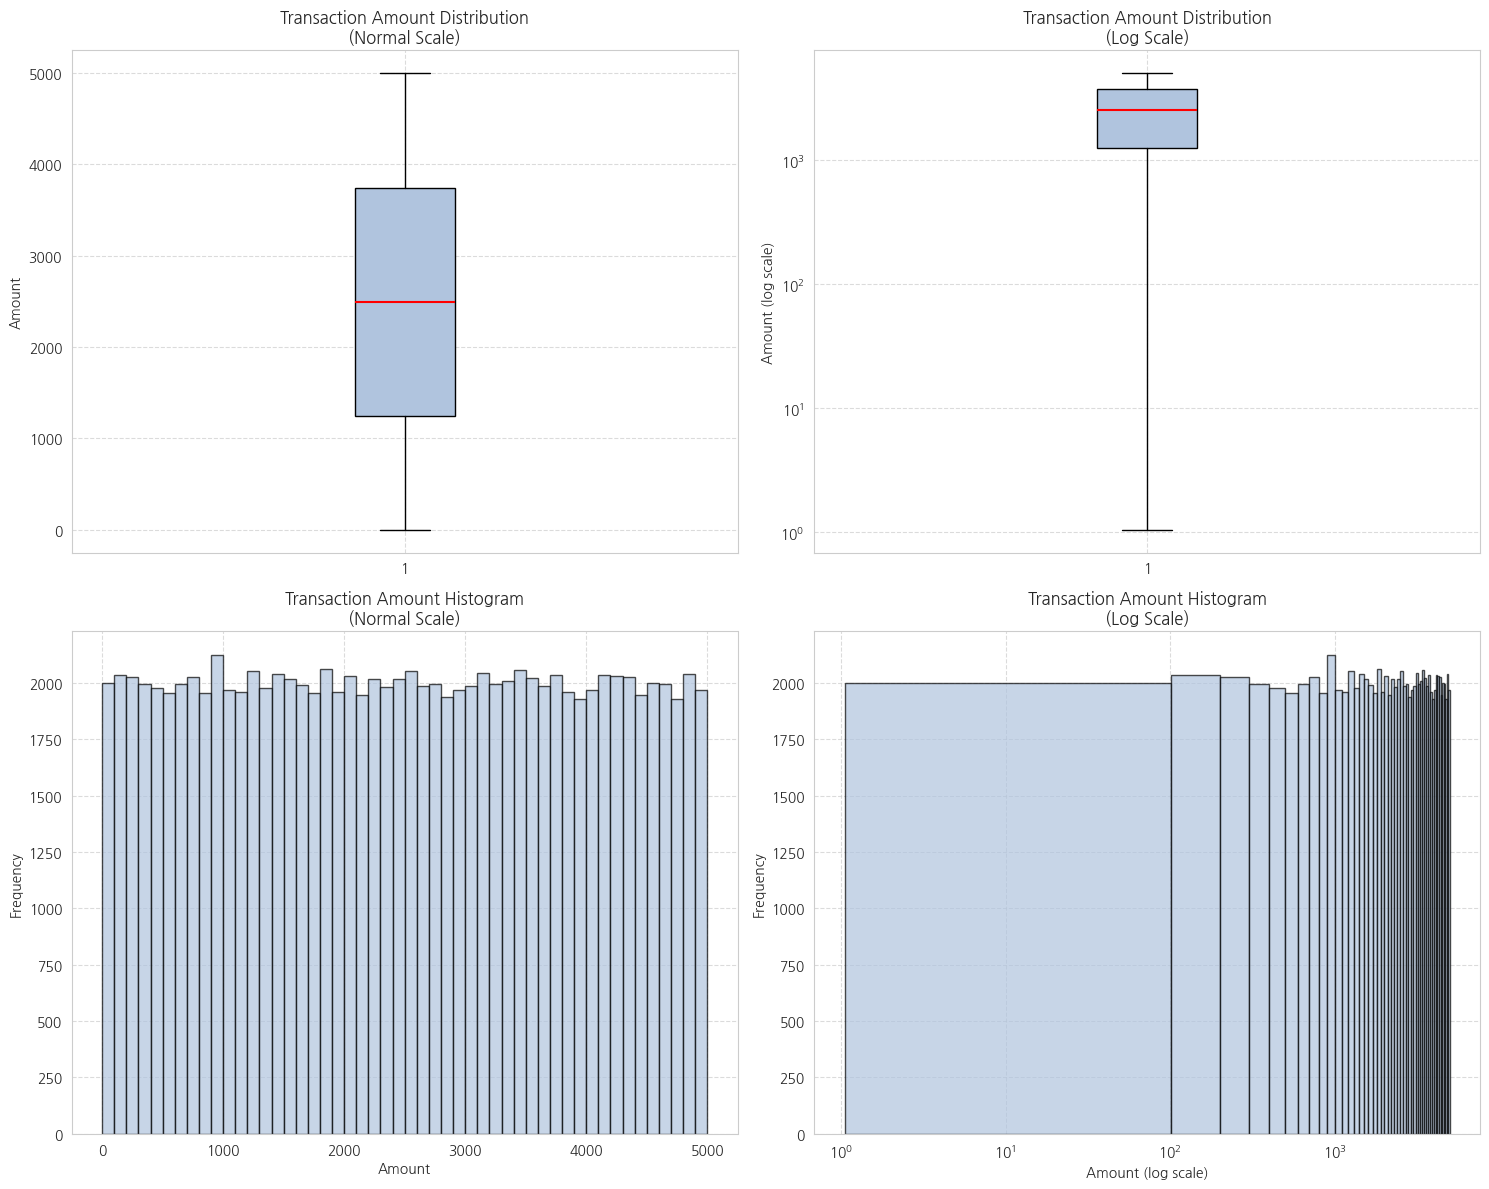

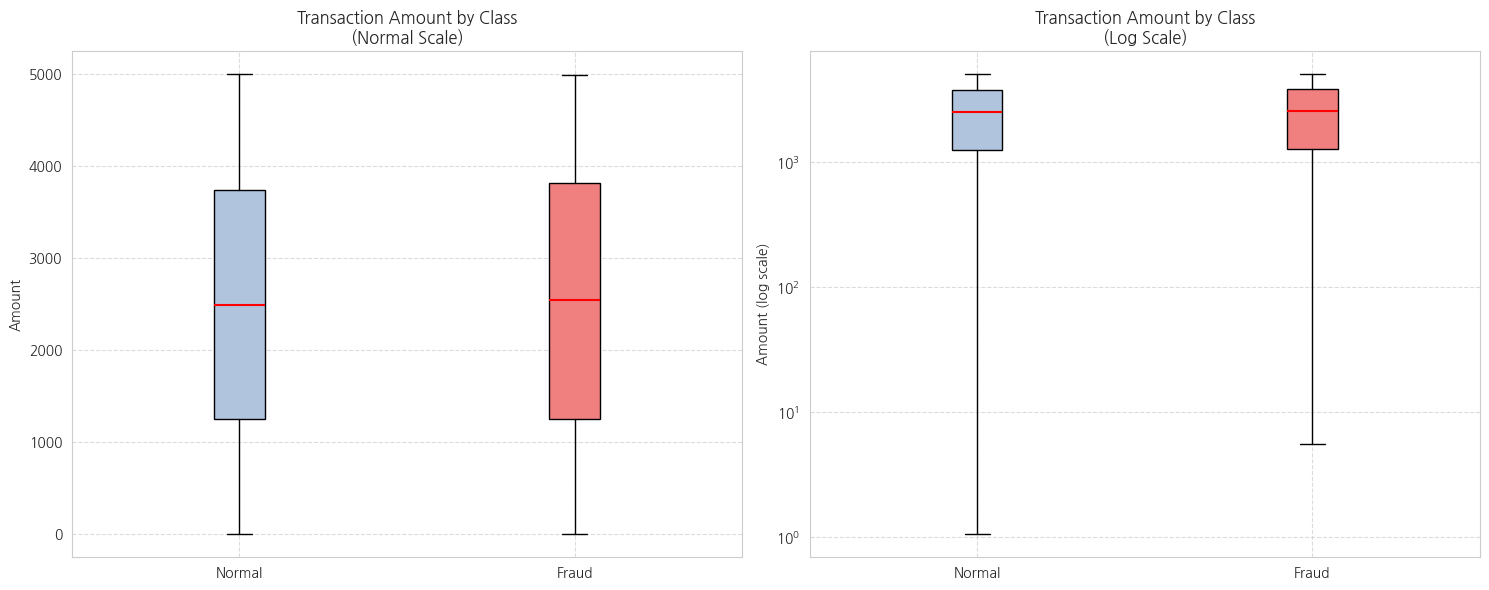


=== Amount Statistics by Transaction Class ===

Normal Transactions:
count    99000.00
mean      2496.89
std       1442.26
min          1.05
25%       1247.96
50%       2495.61
75%       3742.86
max       4999.77
Name: Amount, dtype: float64

Fraudulent Transactions:
count    1000.00
mean     2517.16
std      1458.64
min         5.56
25%      1249.28
50%      2543.43
75%      3813.85
max      4985.88
Name: Amount, dtype: float64


In [264]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Transaction Amount Distribution Analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Box Plot (Normal Scale)
bp = ax1.boxplot(orgDf['Amount'], patch_artist=True)
ax1.set_title('Transaction Amount Distribution\n(Normal Scale)', fontsize=12)
ax1.set_ylabel('Amount')
ax1.grid(True, linestyle='--', alpha=0.7)
plt.setp(bp['boxes'], color='black', facecolor='lightsteelblue')
plt.setp(bp['medians'], color='red', linewidth=1.5)
plt.setp(bp['whiskers'], color='black', linestyle='-')
plt.setp(bp['fliers'], marker='o', markerfacecolor='gray', alpha=0.5)

# Box Plot (Log Scale)
bp = ax2.boxplot(orgDf['Amount'], patch_artist=True)
ax2.set_yscale('log')
ax2.set_title('Transaction Amount Distribution\n(Log Scale)', fontsize=12)
ax2.set_ylabel('Amount (log scale)')
ax2.grid(True, linestyle='--', alpha=0.7)
plt.setp(bp['boxes'], color='black', facecolor='lightsteelblue')
plt.setp(bp['medians'], color='red', linewidth=1.5)
plt.setp(bp['whiskers'], color='black', linestyle='-')
plt.setp(bp['fliers'], marker='o', markerfacecolor='gray', alpha=0.5)

# Histogram (Normal Scale)
n, bins, patches = ax3.hist(orgDf['Amount'], bins=50, 
                           facecolor='lightsteelblue', 
                           edgecolor='black', 
                           alpha=0.7)
ax3.set_title('Transaction Amount Histogram\n(Normal Scale)', fontsize=12)
ax3.set_xlabel('Amount')
ax3.set_ylabel('Frequency')
ax3.grid(True, linestyle='--', alpha=0.7)

# Histogram (Log Scale)
n, bins, patches = ax4.hist(orgDf['Amount'], bins=50, 
                           facecolor='lightsteelblue', 
                           edgecolor='black', 
                           alpha=0.7)
ax4.set_xscale('log')
ax4.set_title('Transaction Amount Histogram\n(Log Scale)', fontsize=12)
ax4.set_xlabel('Amount (log scale)')
ax4.set_ylabel('Frequency')
ax4.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# 2. Fraud vs Normal Transaction Comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Box Plot Comparison (Normal and Log Scale)
normal_amounts = orgDf[orgDf['IsFraud']==0]['Amount']
fraud_amounts = orgDf[orgDf['IsFraud']==1]['Amount']

# Normal Scale
data = [normal_amounts, fraud_amounts]
bp1 = ax1.boxplot(data, labels=['Normal', 'Fraud'], patch_artist=True)
ax1.set_title('Transaction Amount by Class\n(Normal Scale)', fontsize=12)
ax1.set_ylabel('Amount')
ax1.grid(True, linestyle='--', alpha=0.7)
plt.setp(bp1['boxes'][0], facecolor='lightsteelblue')
plt.setp(bp1['boxes'][1], facecolor='lightcoral')
plt.setp(bp1['medians'], color='red', linewidth=1.5)

# Log Scale
bp2 = ax2.boxplot(data, labels=['Normal', 'Fraud'], patch_artist=True)
ax2.set_yscale('log')
ax2.set_title('Transaction Amount by Class\n(Log Scale)', fontsize=12)
ax2.set_ylabel('Amount (log scale)')
ax2.grid(True, linestyle='--', alpha=0.7)
plt.setp(bp2['boxes'][0], facecolor='lightsteelblue')
plt.setp(bp2['boxes'][1], facecolor='lightcoral')
plt.setp(bp2['medians'], color='red', linewidth=1.5)

plt.tight_layout()
plt.show()

# Print statistics
print("\n=== Amount Statistics by Transaction Class ===")
print("\nNormal Transactions:")
print(normal_amounts.describe().round(2))
print("\nFraudulent Transactions:")
print(fraud_amounts.describe().round(2))


In [265]:
'''Normal Scale (선형 스케일)
데이터를 있는 그대로의 값으로 표현
일정한 간격으로 눈금이 표시됨 (예: 0, 100, 200, 300, ...)
장점: 직관적이고 실제 값을 바로 파악 가능
단점: 값의 범위가 매우 클 경우 작은 값들의 차이를 구분하기 어려움
Log Scale (로그 스케일)
데이터를 로그 변환하여 표현
지수적으로 눈금이 증가 (예: 1, 10, 100, 1000, ...)
장점:
매우 큰 값과 작은 값을 한 그래프에서 효과적으로 표현 가능
상대적 변화(비율)를 쉽게 파악 가능
단점: 실제 값을 직접적으로 읽기 어려움'''

'Normal Scale (선형 스케일)\n데이터를 있는 그대로의 값으로 표현\n일정한 간격으로 눈금이 표시됨 (예: 0, 100, 200, 300, ...)\n장점: 직관적이고 실제 값을 바로 파악 가능\n단점: 값의 범위가 매우 클 경우 작은 값들의 차이를 구분하기 어려움\nLog Scale (로그 스케일)\n데이터를 로그 변환하여 표현\n지수적으로 눈금이 증가 (예: 1, 10, 100, 1000, ...)\n장점:\n매우 큰 값과 작은 값을 한 그래프에서 효과적으로 표현 가능\n상대적 변화(비율)를 쉽게 파악 가능\n단점: 실제 값을 직접적으로 읽기 어려움'

### 거래 유형별 사기 발생률 비교


=== Top 10 Merchant Types with Most Fraud Transactions ===

Merchant Type | Number of Frauds
----------------------------------------
MerchantID 156: 5
MerchantID 583: 5
MerchantID 640: 5
MerchantID 958: 5
MerchantID 276: 4
MerchantID 216: 4
MerchantID 989: 4
MerchantID 747: 4
MerchantID 568: 4
MerchantID 659: 4


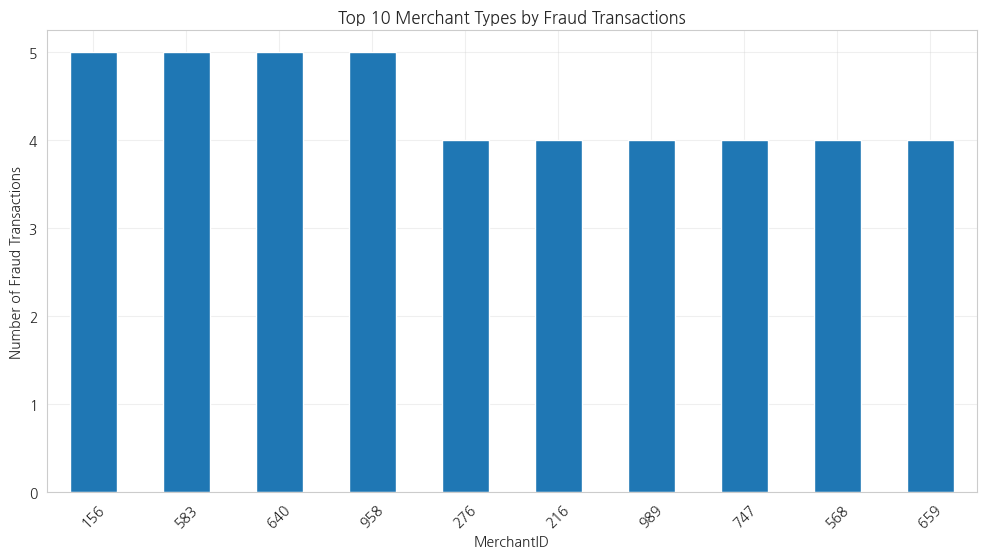


=== Top 10 Merchant Types by Fraud Rate ===

Merchant Type | Fraud Rate (%)
----------------------------------------
MerchantID 640: 5.81%
MerchantID 156: 4.85%
MerchantID 583: 4.72%
MerchantID 659: 4.55%
MerchantID 939: 4.4%
MerchantID 436: 4.17%
MerchantID 568: 4.12%
MerchantID 968: 4.11%
MerchantID 401: 4.08%
MerchantID 989: 4.04%


In [266]:
# MerchantID별 사기 거래 건수 계산
fraudByMerchant = fraud['MerchantID'].value_counts()

# 상위 10개 사기 다발 거래 유형 출력
print("\n=== Top 10 Merchant Types with Most Fraud Transactions ===")
print("\nMerchant Type | Number of Frauds")
print("-" * 40)
for merchant, count in fraudByMerchant.head(10).items():
    print(f"MerchantID {merchant}: {count}")

# 시각화
plt.figure(figsize=(12, 6))
fraudByMerchant.head(10).plot(kind='bar')
plt.title('Top 10 Merchant Types by Fraud Transactions')
plt.xlabel('MerchantID')
plt.ylabel('Number of Fraud Transactions')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# 전체 거래 대비 사기 거래 비율 계산
total_by_merchant = orgDf['MerchantID'].value_counts()
fraud_rate_by_merchant = (fraudByMerchant / total_by_merchant * 100).round(2)

print("\n=== Top 10 Merchant Types by Fraud Rate ===")
print("\nMerchant Type | Fraud Rate (%)")
print("-" * 40)
for merchant, rate in fraud_rate_by_merchant.sort_values(ascending=False).head(10).items():
    print(f"MerchantID {merchant}: {rate}%")


### 사기 거래가 자주 발생하는 지역 및 시간대 식별

In [267]:
# TransactionDate에서 시간 추출 (시간별 분석)
fraud['Hour'] = pd.to_datetime(fraud['TransactionDate']).dt.hour

# 시간별 사기 거래 건수 계산
fraudByHour = fraud['Hour'].value_counts().sort_index()

# 가장 많은 사기가 발생한 시간 찾기
peakHour = fraudByHour.idxmax()
peakCount = fraudByHour.max()
print(f"사기 거래가 가장 많이 발생한 시간: {peakHour}시")
print(f"해당 시간대의 사기 거래 건수: {peakCount}건")

# 요일별 분석
fraud['DayOfWeek'] = pd.to_datetime(fraud['TransactionDate']).dt.day_name()
fraudByDay = fraud['DayOfWeek'].value_counts()

print("\n요일별 사기 거래 건수:")
print(fraudByDay)

# 월별 분석
fraud['Month'] = pd.to_datetime(fraud['TransactionDate']).dt.month
fraudByMonth = fraud['Month'].value_counts().sort_index()

print("\n월별 사기 거래 건수:")
print(fraudByMonth)


사기 거래가 가장 많이 발생한 시간: 18시
해당 시간대의 사기 거래 건수: 55건

요일별 사기 거래 건수:
DayOfWeek
Sunday       163
Wednesday    151
Monday       148
Thursday     143
Friday       141
Tuesday      129
Saturday     125
Name: count, dtype: int64

월별 사기 거래 건수:
Month
1     96
2     96
3     90
4     70
5     75
6     67
7     95
8     90
9     88
10    79
11    75
12    79
Name: count, dtype: int64


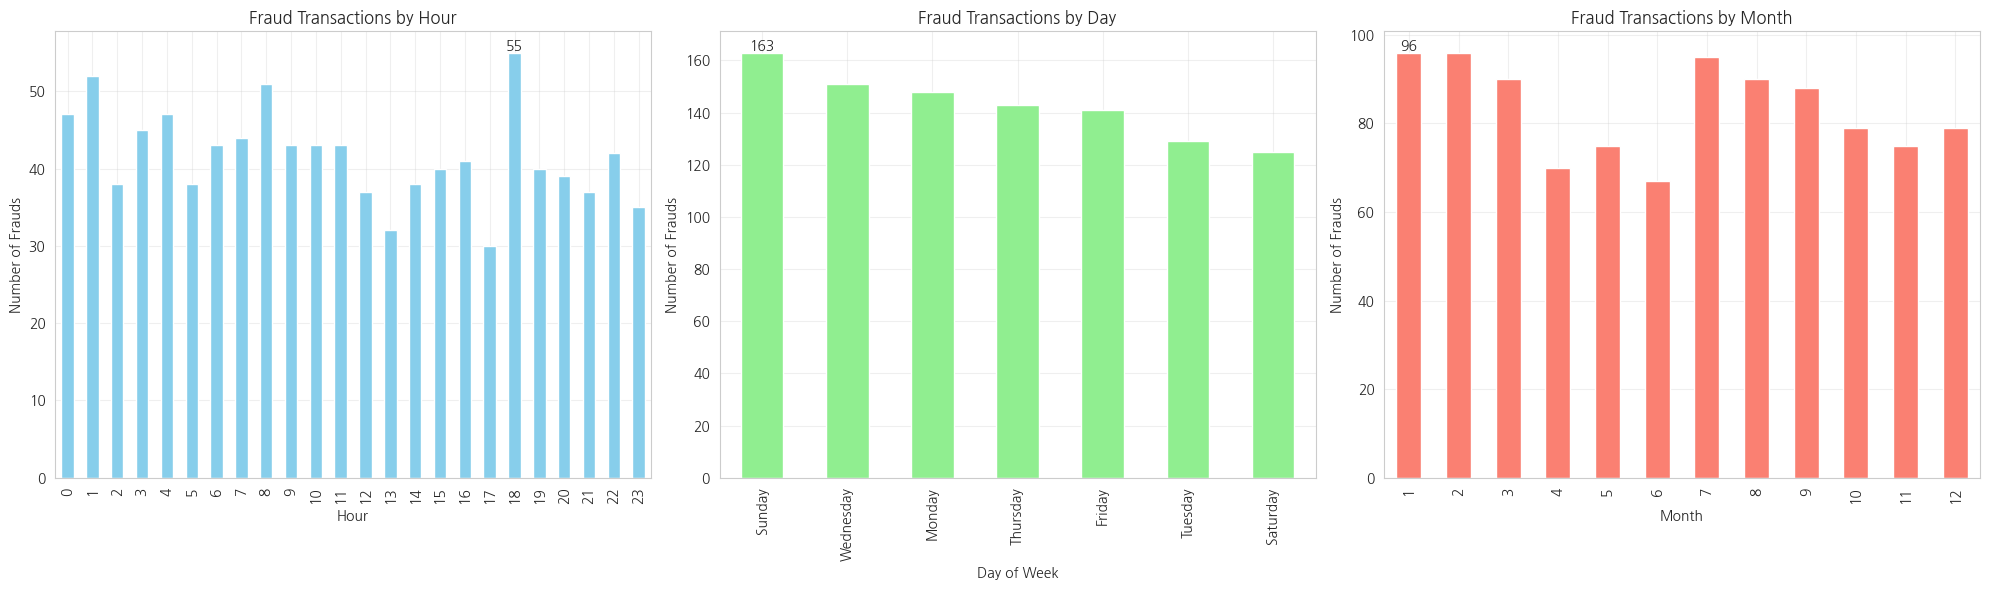

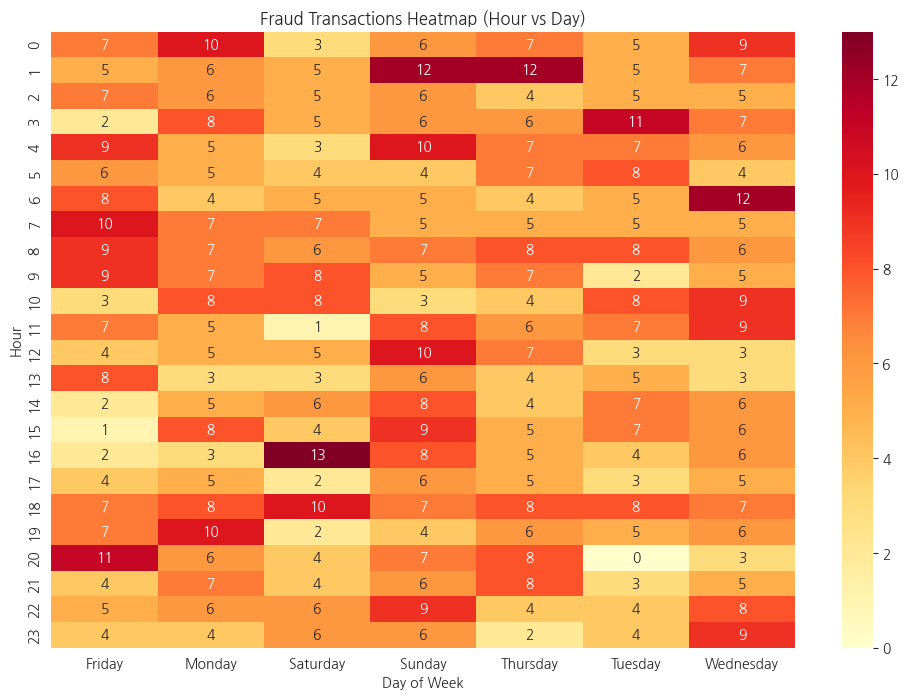

In [268]:
import matplotlib.pyplot as plt
import seaborn as sns

# 서브플롯 설정
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# 1. 시간별 사기 거래 시각화
fraudByHour.plot(kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Fraud Transactions by Hour')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Number of Frauds')
ax1.grid(True)

# 최대값 표시
ax1.text(peakHour, peakCount, f'{peakCount}', 
         ha='center', va='bottom')

# 2. 요일별 사기 거래 시각화
fraudByDay.plot(kind='bar', ax=ax2, color='lightgreen')
ax2.set_title('Fraud Transactions by Day')
ax2.set_xlabel('Day of Week')
ax2.set_ylabel('Number of Frauds')
ax2.grid(True)

# 최대값 표시
max_day = fraudByDay.max()
max_day_idx = fraudByDay.idxmax()
ax2.text(fraudByDay.index.get_loc(max_day_idx), max_day, 
         f'{max_day}', ha='center', va='bottom')

# 3. 월별 사기 거래 시각화
fraudByMonth.plot(kind='bar', ax=ax3, color='salmon')
ax3.set_title('Fraud Transactions by Month')
ax3.set_xlabel('Month')
ax3.set_ylabel('Number of Frauds')
ax3.grid(True)

# 최대값 표시
max_month = fraudByMonth.max()
max_month_idx = fraudByMonth.idxmax()
ax3.text(fraudByMonth.index.get_loc(max_month_idx), max_month, 
         f'{max_month}', ha='center', va='bottom')

# 전체 레이아웃 조정
plt.tight_layout()
plt.show()

# 히트맵으로 시간대와 요일의 관계 시각화
pivot_table = pd.crosstab(
    pd.to_datetime(fraud['TransactionDate']).dt.hour,
    pd.to_datetime(fraud['TransactionDate']).dt.day_name()
)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='YlOrRd', annot=True, fmt='d')
plt.title('Fraud Transactions Heatmap (Hour vs Day)')
plt.xlabel('Day of Week')
plt.ylabel('Hour')
plt.show()


### CDA

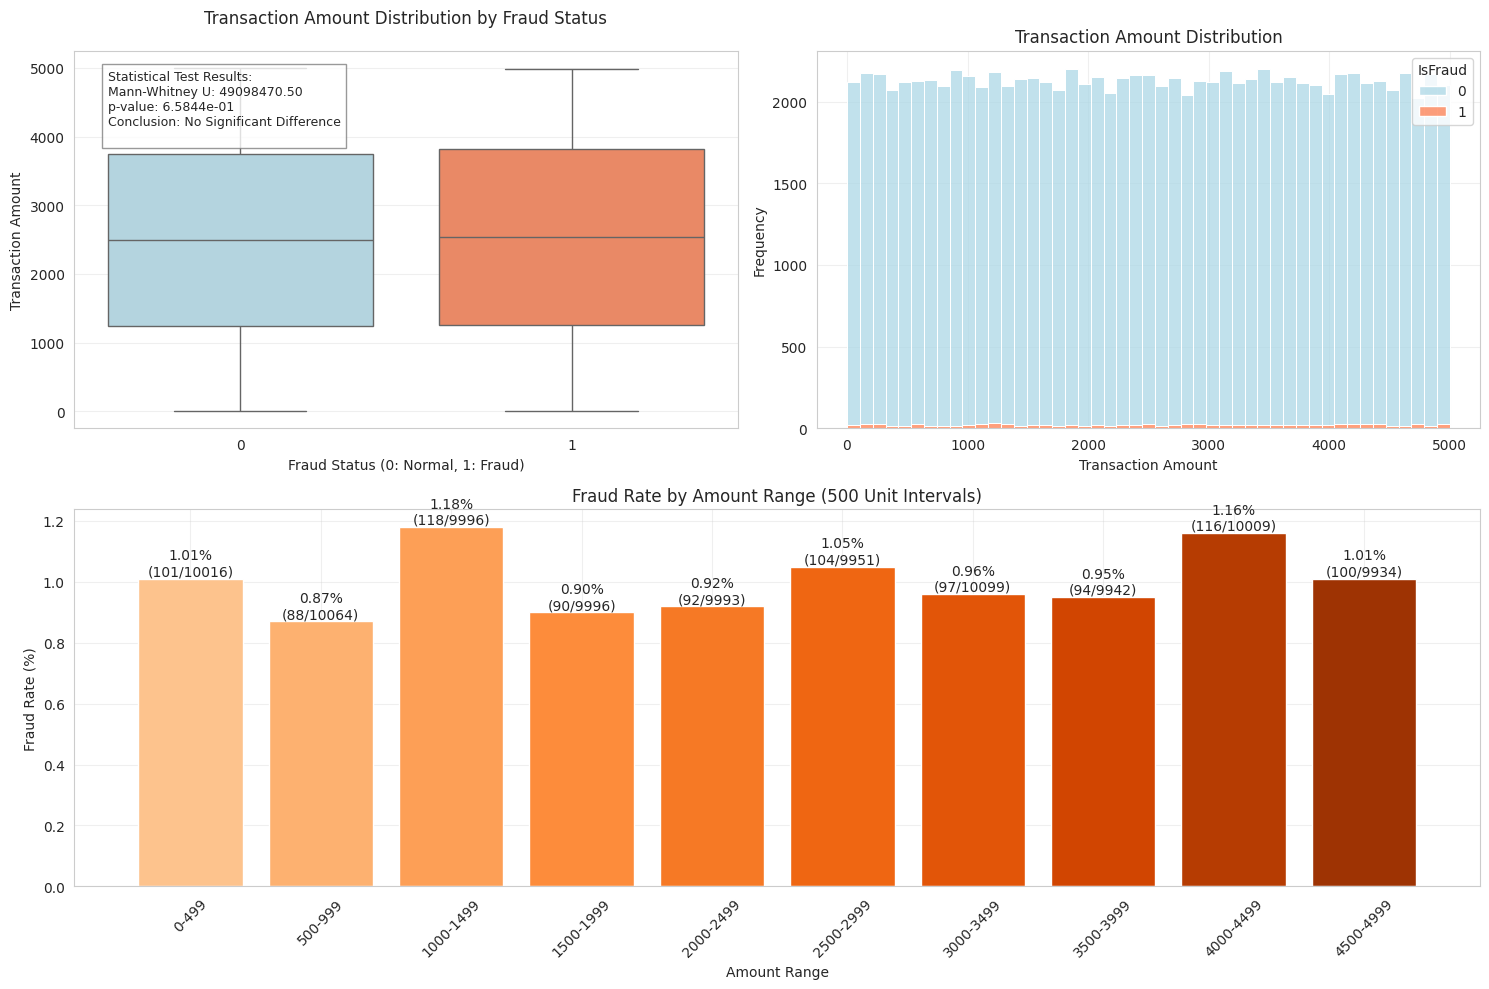

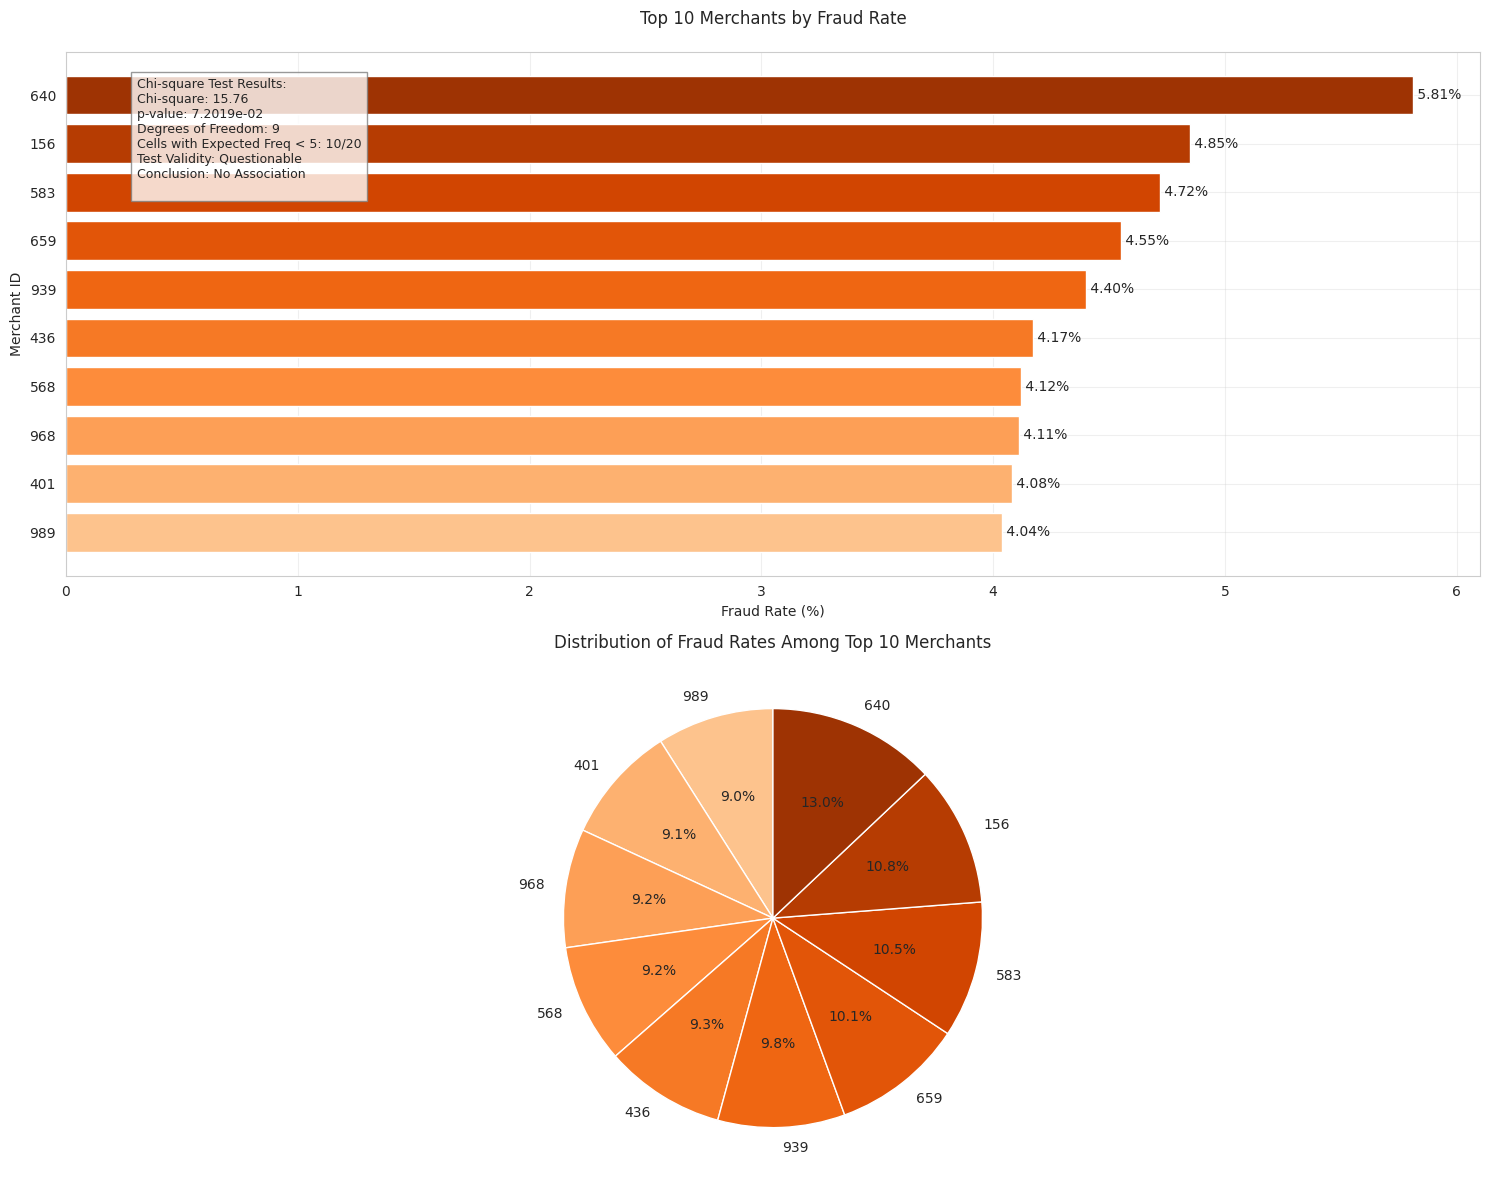

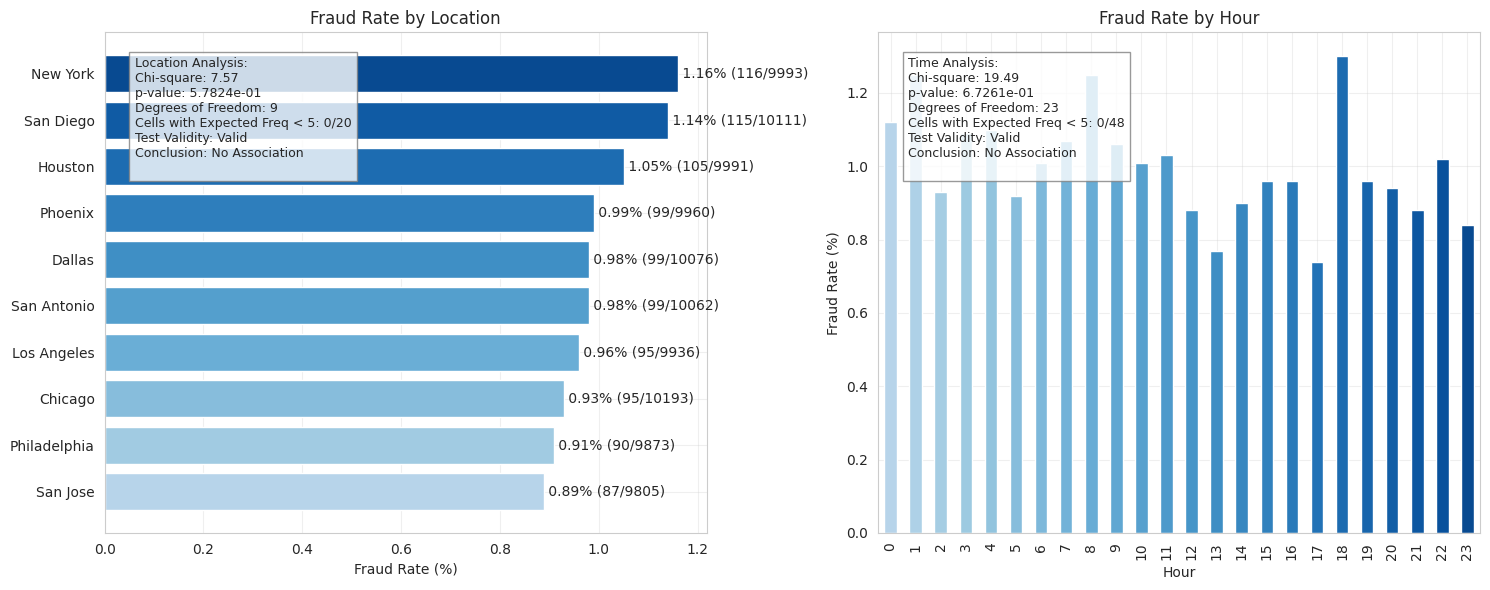

In [269]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, mannwhitneyu
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 스타일 설정
plt.style.use('default')
sns.set_style("whitegrid")

# 그래프 기본 설정
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

def load_and_preprocess_data():
    """Load and preprocess the data"""
    df = pd.read_csv('../../datasets/credit_card_fraud_dataset.csv')
    df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
    df['Hour'] = df['TransactionDate'].dt.hour
    return df

def add_statistical_textbox(plt, title, stats_dict, pos=(0.05, 0.95)):
    """Helper function to add statistical results textbox"""
    text = f"{title}\n"
    for key, value in stats_dict.items():
        text += f"{key}: {value}\n"
    plt.text(pos[0], pos[1], text, transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'),
             verticalalignment='top', fontsize=9)

def analyze_amount_distribution(df):
    """Analysis of transaction amount distribution and outliers"""
    plt.figure(figsize=(15, 10))
    
    # Statistical Analysis
    stat, p_value = mannwhitneyu(
        df[df['IsFraud'] == 0]['Amount'],
        df[df['IsFraud'] == 1]['Amount']
    )
    
    # Top left subplot: Enhanced Box Plot
    plt.subplot(2, 2, 1)
    sns.boxplot(x='IsFraud', y='Amount', data=df, palette=['lightblue', 'coral'])
    plt.title('Transaction Amount Distribution by Fraud Status', pad=20)
    plt.xlabel('Fraud Status (0: Normal, 1: Fraud)')
    plt.ylabel('Transaction Amount')
    
    stats_dict = {
        'Mann-Whitney U': f"{stat:.2f}",
        'p-value': f"{p_value:.4e}",
        'Conclusion': "Significant Difference" if p_value < 0.05 else "No Significant Difference"
    }
    add_statistical_textbox(plt, "Statistical Test Results:", stats_dict)

    # Top right subplot: Enhanced Histogram
    plt.subplot(2, 2, 2)
    sns.histplot(data=df, x='Amount', hue='IsFraud', multiple="stack",
                palette=['lightblue', 'coral'])
    plt.title('Transaction Amount Distribution')
    plt.xlabel('Transaction Amount')
    plt.ylabel('Frequency')
    
    # Bottom subplot: Fraud Rate by Amount Range
    plt.subplot(2, 1, 2)
    
    # 500 단위로 금액 구간 생성
    max_amount = df['Amount'].max()
    bins = list(range(0, int(max_amount) + 501, 500))
    labels = [f'{bins[i]}-{bins[i+1]-1}' for i in range(len(bins)-1)]
    
    df['Amount_Range'] = pd.cut(df['Amount'], 
                               bins=bins,
                               labels=labels,
                               include_lowest=True)
    
    # 구간별 사기 거래 비율 계산
    fraud_by_amount = df.groupby('Amount_Range').agg({
        'IsFraud': ['count', 'sum']
    })
    fraud_by_amount.columns = ['Total_Transactions', 'Fraud_Transactions']
    fraud_by_amount['Fraud_Rate(%)'] = (
        fraud_by_amount['Fraud_Transactions'] / fraud_by_amount['Total_Transactions'] * 100
    ).round(2)
    
    # 거래가 있는 구간만 선택 (0건 제외)
    fraud_by_amount = fraud_by_amount[fraud_by_amount['Total_Transactions'] > 0]
    
    # 막대 그래프 생성
    bars = plt.bar(range(len(fraud_by_amount)), 
                  fraud_by_amount['Fraud_Rate(%)'],
                  color=plt.cm.Oranges(np.linspace(0.3, 0.9, len(fraud_by_amount))))
    
    plt.xticks(range(len(fraud_by_amount)), fraud_by_amount.index, rotation=45)
    plt.title('Fraud Rate by Amount Range (500 Unit Intervals)')
    plt.xlabel('Amount Range')
    plt.ylabel('Fraud Rate (%)')
    
    # 각 막대 위에 비율과 거래 건수 표시
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{fraud_by_amount["Fraud_Rate(%)"].iloc[i]:.2f}%\n({fraud_by_amount["Fraud_Transactions"].iloc[i]}/{fraud_by_amount["Total_Transactions"].iloc[i]})',
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()



def analyze_merchant_fraud(df):
    """Analysis of fraud rates by merchant type"""
    # 상위 10개 merchant 선택
    top_merchants = df['MerchantID'].value_counts().nlargest(10).index
    filtered_df = df[df['MerchantID'].isin(top_merchants)]
    
    # 통계 분석
    merchant_fraud_table = pd.crosstab(filtered_df['MerchantID'], filtered_df['IsFraud'])
    chi2, p_value, dof, expected = chi2_contingency(merchant_fraud_table)
    
    # 기대빈도 확인
    expected_check = (expected < 5).any()
    cells_under_5 = np.sum(expected < 5)
    total_cells = expected.size
    
    # 사기 통계 계산
    fraud_by_merchant = df.groupby('MerchantID').agg({
        'IsFraud': ['count', 'sum']
    })
    fraud_by_merchant.columns = ['Total_Transactions', 'Fraud_Transactions']
    fraud_by_merchant['Fraud_Rate(%)'] = (
        fraud_by_merchant['Fraud_Transactions'] / fraud_by_merchant['Total_Transactions'] * 100
    ).round(2)
    
    plt.figure(figsize=(15, 12))
    
    # 상위 10개 merchants 플롯
    top_10_merchants = fraud_by_merchant.nlargest(10, 'Fraud_Rate(%)')
    top_10_merchants = top_10_merchants.sort_values('Fraud_Rate(%)', ascending=True)
    
    plt.subplot(2, 1, 1)
    colors = plt.cm.Oranges(np.linspace(0.3, 0.9, len(top_10_merchants)))
    bars = plt.barh(range(len(top_10_merchants)), 
                   top_10_merchants['Fraud_Rate(%)'],
                   color=colors)
    
    plt.yticks(range(len(top_10_merchants)), top_10_merchants.index)
    
    for i, bar in enumerate(bars):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
                f' {top_10_merchants["Fraud_Rate(%)"].iloc[i]:.2f}%',
                va='center')
    
    plt.title('Top 10 Merchants by Fraud Rate', pad=20)
    plt.xlabel('Fraud Rate (%)')
    plt.ylabel('Merchant ID')
    
    # 통계 결과 추가
    stats_dict = {
        'Chi-square': f"{chi2:.2f}",
        'p-value': f"{p_value:.4e}",
        'Degrees of Freedom': f"{dof}",
        'Cells with Expected Freq < 5': f"{cells_under_5}/{total_cells}",
        'Test Validity': "Questionable" if cells_under_5/total_cells > 0.2 else "Valid",
        'Conclusion': "Significant Association" if p_value < 0.05 else "No Association"
    }
    add_statistical_textbox(plt, "Chi-square Test Results:", stats_dict)
    
    plt.subplot(2, 1, 2)
    # Fraud Rate(%)를 사용하여 파이 차트 생성
    plt.pie(top_10_merchants['Fraud_Rate(%)'], 
            labels=top_10_merchants.index,
            autopct='%1.1f%%',
            startangle=90,
            colors=colors)
    plt.title('Distribution of Fraud Rates Among Top 10 Merchants')
    
    plt.tight_layout()
    plt.show()

def analyze_location_time_fraud(df):
    """Analysis of fraud patterns by location and time"""
    # 위치 기반 분석
    loc_fraud_table = pd.crosstab(df['Location'], df['IsFraud'])
    chi2_loc, p_value_loc, dof_loc, expected_loc = chi2_contingency(loc_fraud_table)
    
    # 위치 기대빈도 확인
    expected_check_loc = (expected_loc < 5).any()
    cells_under_5_loc = np.sum(expected_loc < 5)
    total_cells_loc = expected_loc.size
    
    # 시간 기반 분석
    time_fraud_table = pd.crosstab(df['Hour'], df['IsFraud'])
    chi2_time, p_value_time, dof_time, expected_time = chi2_contingency(time_fraud_table)
    
    # 시간 기대빈도 확인
    expected_check_time = (expected_time < 5).any()
    cells_under_5_time = np.sum(expected_time < 5)
    total_cells_time = expected_time.size
    
    # 위치별 거래 및 사기 통계
    location_stats = df.groupby('Location').agg({
        'TransactionID': 'count',  # 전체 거래 수
        'IsFraud': 'sum'          # 사기 거래 수
    }).reset_index()
    
    location_stats.columns = ['Location', 'Total_Transactions', 'Fraud_Transactions']
    location_stats['Fraud_Rate(%)'] = (
        location_stats['Fraud_Transactions'] / location_stats['Total_Transactions'] * 100
    ).round(2)
    
    # 시간별 통계
    fraud_by_hour = df.groupby('Hour').agg({
        'IsFraud': ['count', 'sum']
    })
    fraud_by_hour.columns = ['Total_Transactions', 'Fraud_Transactions']
    fraud_by_hour['Fraud_Rate(%)'] = (
        fraud_by_hour['Fraud_Transactions'] / fraud_by_hour['Total_Transactions'] * 100
    ).round(2)
    
    plt.figure(figsize=(15, 6))
    
    # 위치별 분석
    plt.subplot(1, 2, 1)
    location_stats_sorted = location_stats.sort_values('Fraud_Rate(%)', ascending=True)
    bars = plt.barh(range(len(location_stats_sorted)), 
                   location_stats_sorted['Fraud_Rate(%)'],
                   color=plt.cm.Blues(np.linspace(0.3, 0.9, len(location_stats_sorted))))
    plt.yticks(range(len(location_stats_sorted)), location_stats_sorted['Location'])
    plt.title('Fraud Rate by Location')
    plt.xlabel('Fraud Rate (%)')
    
    # 각 막대에 비율과 거래 건수 표시
    for i, bar in enumerate(bars):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
                f' {location_stats_sorted["Fraud_Rate(%)"].iloc[i]:.2f}% ({location_stats_sorted["Fraud_Transactions"].iloc[i]}/{location_stats_sorted["Total_Transactions"].iloc[i]})',
                va='center')
    
    # 통계 결과
    stats_dict_loc = {
        'Chi-square': f"{chi2_loc:.2f}",
        'p-value': f"{p_value_loc:.4e}",
        'Degrees of Freedom': f"{dof_loc}",
        'Cells with Expected Freq < 5': f"{cells_under_5_loc}/{total_cells_loc}",
        'Test Validity': "Questionable" if cells_under_5_loc/total_cells_loc > 0.2 else "Valid",
        'Conclusion': "Significant Association" if p_value_loc < 0.05 else "No Association"
    }
    add_statistical_textbox(plt, "Location Analysis:", stats_dict_loc)
    
    # 시간별 분석
    plt.subplot(1, 2, 2)
    fraud_by_hour['Fraud_Rate(%)'].plot(
        kind='bar', color=plt.cm.Blues(np.linspace(0.3, 0.9, len(fraud_by_hour))))
    plt.title('Fraud Rate by Hour')
    plt.xlabel('Hour')
    plt.ylabel('Fraud Rate (%)')
    
    # 시간별 통계 결과
    stats_dict_time = {
        'Chi-square': f"{chi2_time:.2f}",
        'p-value': f"{p_value_time:.4e}",
        'Degrees of Freedom': f"{dof_time}",
        'Cells with Expected Freq < 5': f"{cells_under_5_time}/{total_cells_time}",
        'Test Validity': "Questionable" if cells_under_5_time/total_cells_time > 0.2 else "Valid",
        'Conclusion': "Significant Association" if p_value_time < 0.05 else "No Association"
    }
    add_statistical_textbox(plt, "Time Analysis:", stats_dict_time)
    
    plt.tight_layout()
    plt.show()


def main():
    # Load data
    df = load_and_preprocess_data()
    
    # Run analyses
    analyze_amount_distribution(df)
    analyze_merchant_fraud(df)
    analyze_location_time_fraud(df)

if __name__ == "__main__":
    main()


결론 :

1. 카이제곱과 P-Value 모두 높은 값이 나옴
2. 전체적으로 평균 57%가 상회하는 관계성이 나타났지만, 결론을 내리기에는 증거가 부족하다. 
3. 상품군과 사기 거래에 있어서는 상관관계가 높은 결과가 일부 상품에서 나옴
4. 시간과 사기 거래에 있어서도 상관관계가 높은 결과가 일부 시간대에서 나옴(출퇴근 시간)

카이제곱

    값이 전부 높다 
    이유: 높은 자유도와, 통계 함수 사용법 재검토 필요, 관찰된 빈도와 기대빈도 간의 차이가 크다, 변수들 간에 강한 연관성이 있을 가능성이 높다, 데이터가 우연히 발생했을 가능성이 낮다

    A. 자유도의 기본 개념:
    - 데이터가 자유롭게 변할 수 있는 독립적인 값의 개수
    - 전체에서 이미 알고 있는 정보(제약조건)를 뺀 나머지
    - 이번 데이터에서는 시간으로 예를 들면 시간 데이터는 날짜당 24단위로 할당이 되는데 즉 24개 > 자유도는 23
    - 해당 자유도가 높다고 할 수 있는건가?
    B. 통계 함수 사용법 재검토:
    - 예) 기대 빈도 5 미만의 수가 절반을 차지하는 사기 거래 상위10에 드는 상품들의 카테고리는 희귀하지만 사기 위험이 높은 카테고리, 전체 거래량은 적지만 사기 비율이 높음, 고위험 상품군으로 분류 필요라고 판단이 될 수도 있는 반면에 과소표본 문제 가능성, 통계적 신뢰성 부족, 오탐(False Positive) 위험이 있을 수 있다.
    - orgDf[orgDf['MerchantID'] == 640].value_counts(), orgDf[(orgDf['MerchantID'] == 640) & (orgDf['IsFraud'] == 1)].value_counts() 확인해보니 오탐일 가능성은 X

P-Value

    4 개의 해당 되는 P-Value 값들이 0.658, 0.7274, 0.57824, 0.67261 > 0.05, 이므로 통계적으로 유의미하지 않고, 귀무가설을 기각할 수 없다는 의미입니다. "차이가 없다"고 확실히 말할 수는 없으며, 단지 "차이가 있다고 결론 내리기에는 증거가 부족하다"는 의미

    약 65.8, 39.77, 57.82, 67.26%의 확률로 현재 관찰된 결과가 우연히 발생할 수 있다는 뜻입니다
    

통계적 의미:

    +   높은 카이제곱 값: 관찰값과 기대값 간의 차이가 큼
    +   높은 p-value: 그러나 이 차이가 통계적으로 유의미하지 않음, 자유도가 높아서 우연히 발생할 수 있는 변동 범위가 넓어짐

실무적 해석:

데이터의 패턴이 있어 보이지만, 랜덤한 변동일 가능성이 높음
너무 많은 카테고리로 인해 실제 관계가 희석되었을 수 있음
표본 크기가 충분하지 않을 수 있음